- 使用ICA拟合MEG源数据
- 自动找到ECG和EOG并展示
- 伪迹检测并去除

In [1]:
import numpy as np
import mne
from mne.preprocessing import ICA
from mne.preprocessing import create_ecg_epochs,create_eog_epochs
from mne.datasets import sample

Opening raw data file /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 497 samples (3.310 sec) selected


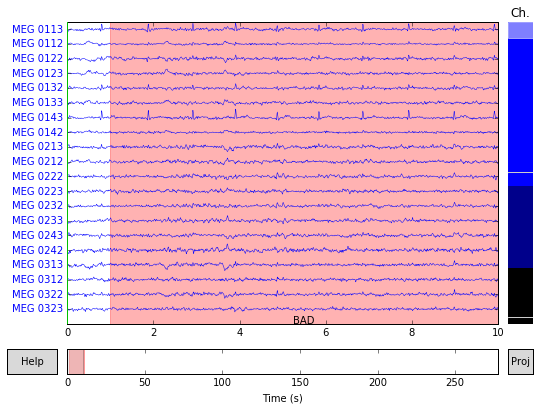

In [9]:
data_path = sample.data_path()
raw_name = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_name,preload=True)
raw.filter(1,None,fir_design='firwin') # 源数据已经做过40Hz低通滤波
# For the sake of example we annotate first 10 seconds of the recording as
# 'BAD'. This part of data is excluded from the ICA decomposition by default.
# To turn this behavior off, pass ``reject_by_annotation=False`` to
# :meth:`mne.preprocessing.ICA.fit`.
raw.set_annotations(mne.Annotations([1],[10],'BAD'))  # https://martinos.org/mne/stable/generated/mne.Annotations.html
raw.plot(block=True);


#### 1. Fit ICA model using the FastICA algorithm.

In [11]:
## We pass a float value between 0 and 1 to select n_components based on the percentage of variance explained by the PCA components
ica = ICA(n_components=0.95,method='fastica',random_state=0,max_iter=1000)
picks = mne.pick_types(raw.info,meg=True,eeg=False,eog=False,stim=False,exclude='bads')
## low iterations -> does not fully converge
ica.fit(raw,picks=picks,decim=3,reject=dict(mag=4e-12,grad=4000e-13))
# maximum number of components to reject
n_max_ecg, n_max_eog = 3, 1  # here we don't expect horizontal EOG components

Fitting ICA to data using 305 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on MAG : [u'MEG 1711']
Artifact detected in [3737, 3838]
    Rejecting  epoch based on MAG : [u'MEG 1711']
Artifact detected in [5353, 5454]
    Rejecting  epoch based on MAG : [u'MEG 1411']
Artifact detected in [12827, 12928]
    Rejecting  epoch based on MAG : [u'MEG 1411']
Artifact detected in [12928, 13029]
Selection by explained variance: 123 components
Fitting ICA took 62.5s.


#### 2. Identify bad components by analyzing latent sources

In [20]:
title = 'Sources related to %s artifacts (red)'
# generate ECG epochs use detection via phase statistics
ecg_epochs = create_ecg_epochs(raw,tmin=-.5, tmax=.5, picks=picks)
ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, method='ctps')


Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz
Filter length of 2048 samples (13.639 sec) selected
Number of ECG events detected : 284 (average pulse 61 / min.)
284 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 284 events and 151 original time points ...
11 bad epochs dropped
Reconstructing ECG signal from Magnetometers


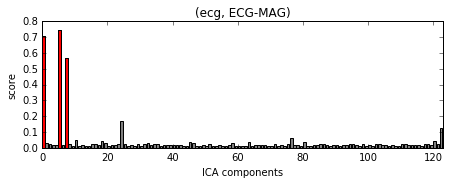

In [18]:
ica.plot_scores(scores,exclude=ecg_inds,title=title % 'ecg',labels='ecg');

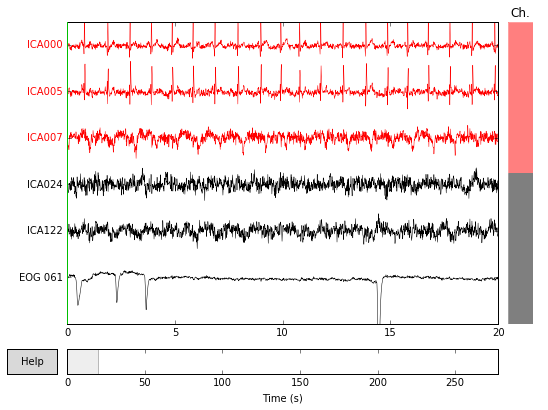

In [30]:
show_picks = np.abs(scores).argsort()[::-1][:5] ## 返回从大到小排序的前5个索引
ica.plot_sources(raw,show_picks,exclude=ecg_inds,title=title % 'ecg');

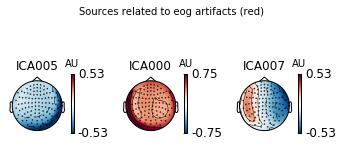

In [31]:
ica.plot_components(ecg_inds,title=title % 'eog',colorbar=True);

In [34]:
ecg_inds = ecg_inds[:n_max_ecg]
ica.exclude += ecg_inds

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz
Filter length of 2048 samples (13.639 sec) selected
... filtering target
Setting up band-pass filter from 1 - 10 Hz
Filter length of 2048 samples (13.639 sec) selected


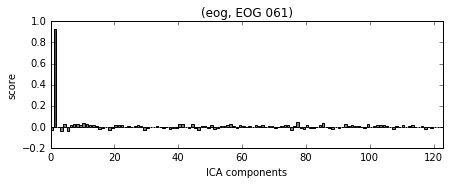

In [35]:
# detect EOG by correlation
eog_inds,scores = ica.find_bads_eog(raw)
ica.plot_scores(scores,exclude=eog_inds,title=title % 'eog',labels='eog');

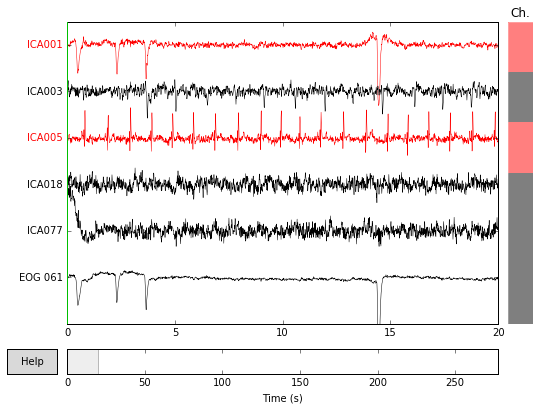

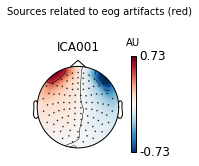

In [37]:
show_picks = np.abs(scores).argsort()[::-1][:5]
ica.plot_sources(raw,show_picks,exclude=eog_inds,title=title % 'eog')
ica.plot_components(eog_inds,title=title % 'eog',colorbar=True);

In [39]:
eog_inds = eog_inds[:n_max_eog]
ica.exclude += eog_inds

#### 3.Assess component selection and unmixing quality.

In [40]:
ecg_epochs

<Epochs  |   273 events (all good), -0.499488 - 0.499488 sec, baseline off, ~99.5 MB, data loaded,
 '999': 273>

In [41]:
## estimate average artifact
ecg_evoked = ecg_epochs.average()
ecg_evoked

<Evoked  |  '999' (mean, N=273), [-0.49949, 0.49949] sec, 305 ch, ~3.9 MB>

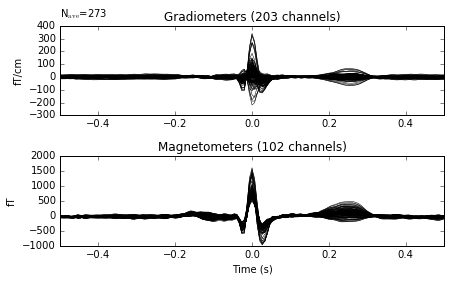

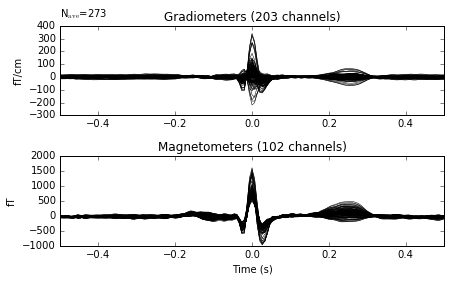

In [58]:
ecg_evoked.plot()

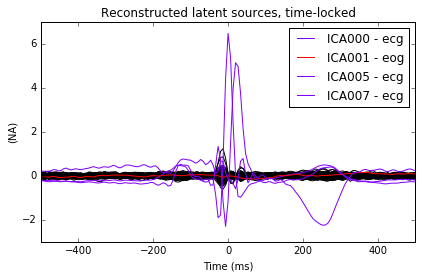

In [44]:
ica.plot_sources(ecg_evoked,exclude=ecg_inds); # plot ECG sources + selection

Transforming to ICA space (123 components)
Zeroing out 4 ICA components


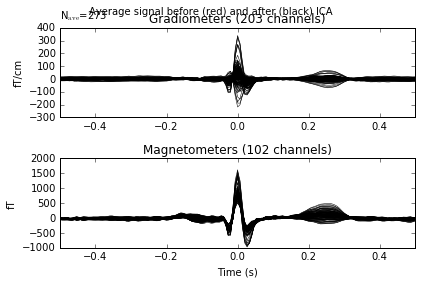

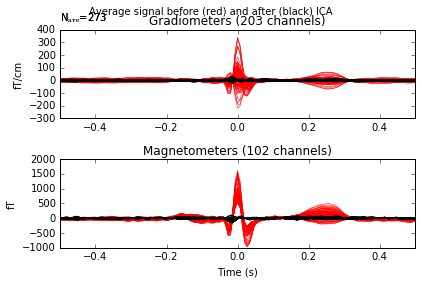

In [49]:
ica.plot_overlay(ecg_evoked,exclude=ecg_inds) # plot ECG cleaning

EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 2048 samples (13.639 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 2048 samples (13.639 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 44
44 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 44 events and 151 original time points ...
1 bad epochs dropped


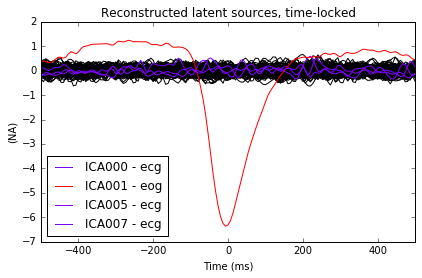

Transforming to ICA space (123 components)
Zeroing out 4 ICA components


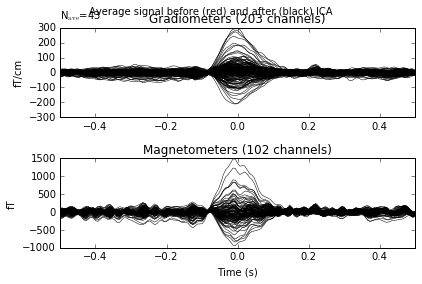

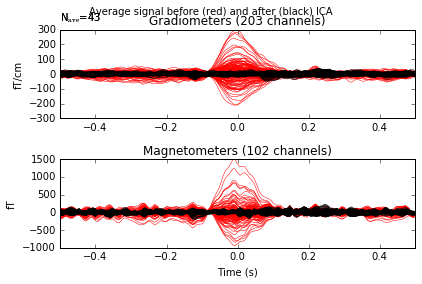

In [50]:
eog_evoked = create_eog_epochs(raw,tmin=-.5,tmax=.5,picks=picks).average()
ica.plot_sources(eog_evoked,exclude=eog_inds); # plot EOG sources + selection
ica.plot_overlay(eog_evoked,exclude=eog_inds) ## plot EOG cleaning

Transforming to ICA space (123 components)
Zeroing out 4 ICA components


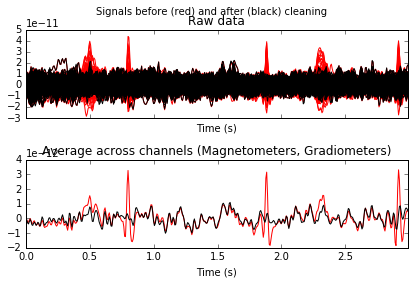

In [52]:
# check the amplitudes do not change
ica.plot_overlay(raw);  # EOG artifacts remain

In [ ]:
# To save an ICA solution you can say:
# ica.save('my_ica.fif')

# You can later load the solution by saying:
# from mne.preprocessing import read_ica
# read_ica('my_ica.fif')

# Apply the solution to Raw, Epochs or Evoked like this:
# ica.apply(epochs)